The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Residual Networks (ResNet) and ResNeXt
:label:`sec_resnet`

As we design ever deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network.
Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different.
To make some progress we need a bit of mathematics.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach.
That is, for all $f \in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.
Let's assume that $f^*$ is the "truth" function that we really would like to find.
If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky.
Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$.
For instance,
given a dataset with features $\mathbf{X}$
and labels $\mathbf{y}$,
we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} \stackrel{\textrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \textrm{ subject to } f \in \mathcal{F}.$$

We know that regularization :cite:`tikhonov1977solutions,morozov2012methods` may control complexity of $\mathcal{F}$
and achieve consistency, so a larger size of training data
generally leads to better $f^*_\mathcal{F}$.
It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse.
As illustrated by :numref:`fig_functionclasses`,
for non-nested function classes, a larger function class does not always move closer to the "truth" function $f^*$. For instance,
on the left of :numref:`fig_functionclasses`,
though $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f^*$.
With nested function classes
where $\mathcal{F}_1 \subseteq \cdots \subseteq \mathcal{F}_6$
on the right of :numref:`fig_functionclasses`,
we can avoid the aforementioned issue from the non-nested function classes.


![For non-nested function classes, a larger (indicated by area) function class does not guarantee we will get closer to the "truth" function ($\mathit{f}^*$). This does not happen in nested function classes.](http://d2l.ai/_images/functionclasses.svg)
:label:`fig_functionclasses`

Thus,
only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.
For deep neural networks,
if we can
train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

This is the question that :citet:`He.Zhang.Ren.ea.2016` considered when working on very deep computer vision models.
At the heart of their proposed *residual network* (*ResNet*) is the idea that every additional layer should
more easily
contain the identity function as one of its elements.
These considerations are rather profound but they led to a surprisingly simple
solution, a *residual block*.
With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to
build deep neural networks. For instance, residual blocks have been added to recurrent networks :cite:`prakash2016neural,kim2017residual`. Likewise, Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017` use them to stack many layers of networks efficiently. It is also used in graph neural networks :cite:`Kipf.Welling.2016` and, as a basic concept, it has been used extensively in computer vision :cite:`Redmon.Farhadi.2018,Ren.He.Girshick.ea.2015`. 
Note that residual networks are predated by highway networks :cite:`srivastava2015highway` that share some of the motivation, albeit without the elegant parametrization around the identity function.


## (**Residual Blocks**)
:label:`subsec_residual-blks`

Let's focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that $f(\mathbf{x})$, the desired underlying mapping we want to obtain by learning, is to be used as input to the activation function on the top.
On the left,
the portion within the dotted-line box
must directly learn $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping amounts to $g(\mathbf{x}) = 0$ and it is thus easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure illustrates the *residual block* of ResNet,
where the solid line carrying the layer input
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can
forward propagate faster through the residual connections across layers.
In fact,
the residual block
can be thought of as
a special case of the multi-branch Inception block:
it has two branches
one of which is the identity mapping.

![In a regular block (left), the portion within the dotted-line box must directly learn the mapping $\mathit{f}(\mathbf{x})$. In a residual block (right), the portion within the dotted-line box needs to learn the residual mapping $\mathit{g}(\mathbf{x}) = \mathit{f}(\mathbf{x}) - \mathbf{x}$, making the identity mapping $\mathit{f}(\mathbf{x}) = \mathbf{x}$ easier to learn.](../img/residual-block.svg)
:label:`fig_residual_block`


ResNet has VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let's have a look at the code below.


In [2]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=False`; and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. :numref:`fig_resnet_block` illustrates this.

![ResNet block with and without $1 \times 1$ convolution, which transforms the input into the desired shape for the addition operation.](../img/resnet-block.svg)
:label:`fig_resnet_block`

Now let's look at [**a situation where the input and output are of the same shape**], where $1 \times 1$ convolution is not needed.


In [3]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

We also have the option to [**halve the output height and width while increasing the number of output channels**].
In this case we use $1 \times 1$ convolutions via `use_1x1conv=True`. This comes in handy at the beginning of each ResNet block to reduce the spatial dimensionality via `strides=2`.


In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet Model**]

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.


In [5]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks.
However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels.
The number of channels in the first module is the same as the number of input channels. Since a max-pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.


In [6]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module. Lastly, just like GoogLeNet, we add a global average pooling layer, followed by the fully connected layer output.


In [7]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

There are four convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

![The ResNet-18 architecture.](../img/resnet18-90.svg)
:label:`fig_resnet18`

Before training ResNet, let's [**observe how the input shape changes across different modules in ResNet**]. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.


In [8]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

In [9]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


## [**Training**]

We train ResNet on the Fashion-MNIST dataset, just like before. ResNet is quite a powerful and flexible architecture. The plot capturing training and validation loss illustrates a significant gap between both graphs, with the training loss being considerably lower. For a network of this flexibility, more training data would offer distinct benefit in closing the gap and improving accuracy.


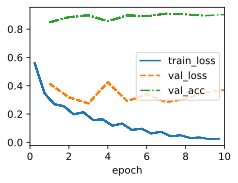

In [10]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## ResNeXt
:label:`subsec_resnext`

One of the challenges one encounters in the design of ResNet is the trade-off between nonlinearity and dimensionality within a given block. That is, we could add more nonlinearity by increasing the number of layers, or by increasing the width of the convolutions. An alternative strategy is to increase the number of channels that can carry information between blocks. Unfortunately, the latter comes with a quadratic penalty since the computational cost of ingesting $c_\textrm{i}$ channels and emitting $c_\textrm{o}$ channels is proportional to $\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$ (see our discussion in :numref:`sec_channels`). 

We can take some inspiration from the Inception block of :numref:`fig_inception` which has information flowing through the block in separate groups. Applying the idea of multiple independent groups to the ResNet block of :numref:`fig_resnet_block` led to the design of ResNeXt :cite:`Xie.Girshick.Dollar.ea.2017`.
Different from the smorgasbord of transformations in Inception, 
ResNeXt adopts the *same* transformation in all branches,
thus minimizing the need for manual tuning of each branch. 

![The ResNeXt block. The use of grouped convolution with $\mathit{g}$ groups is $\mathit{g}$ times faster than a dense convolution. It is a bottleneck residual block when the number of intermediate channels $\mathit{b}$ is less than $\mathit{c}$.](../img/resnext-block.svg)
:label:`fig_resnext_block`

Breaking up a convolution from $c_\textrm{i}$ to $c_\textrm{o}$ channels into one of $g$ groups of size $c_\textrm{i}/g$ generating $g$ outputs of size $c_\textrm{o}/g$ is called, quite fittingly, a *grouped convolution*. The computational cost (proportionally) is reduced from $\mathcal{O}(c_\textrm{i} \cdot c_\textrm{o})$ to $\mathcal{O}(g \cdot (c_\textrm{i}/g) \cdot (c_\textrm{o}/g)) = \mathcal{O}(c_\textrm{i} \cdot c_\textrm{o} / g)$, i.e., it is $g$ times faster. Even better, the number of parameters needed to generate the output is also reduced from a $c_\textrm{i} \times c_\textrm{o}$ matrix to $g$ smaller matrices of size $(c_\textrm{i}/g) \times (c_\textrm{o}/g)$, again a $g$ times reduction. In what follows we assume that both $c_\textrm{i}$ and $c_\textrm{o}$ are divisible by $g$. 

The only challenge in this design is that no information is exchanged between the $g$ groups. The ResNeXt block of 
:numref:`fig_resnext_block` amends this in two ways: the grouped convolution with a $3 \times 3$ kernel is sandwiched in between two $1 \times 1$ convolutions. The second one serves double duty in changing the number of channels back. The benefit is that we only pay the $\mathcal{O}(c \cdot b)$ cost for $1 \times 1$ kernels and can make do with an $\mathcal{O}(b^2 / g)$ cost for $3 \times 3$ kernels. Similar to the residual block implementation in
:numref:`subsec_residual-blks`, the residual connection is replaced (thus generalized) by a $1 \times 1$ convolution.

The right-hand figure in :numref:`fig_resnext_block` provides a much more concise summary of the resulting network block. It will also play a major role in the design of generic modern CNNs in :numref:`sec_cnn-design`. Note that the idea of grouped convolutions dates back to the implementation of AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`. When distributing the network across two GPUs with limited memory, the implementation treated each GPU as its own channel with no ill effects. 

The following implementation of the `ResNeXtBlock` class takes as argument `groups` ($g$), with 
`bot_channels` ($b$) intermediate (bottleneck) channels. Lastly, when we need to reduce the height and width of the representation, we add a stride of $2$ by setting `use_1x1conv=True, strides=2`.


In [11]:
class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

Its use is entirely analogous to that of the `ResNetBlock` discussed previously. For instance, when using (`use_1x1conv=False, strides=1`), the input and output are of the same shape. Alternatively, setting `use_1x1conv=True, strides=2` halves the output height and width.


In [12]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

## Summary and Discussion

Nested function classes are desirable since they allow us to obtain strictly *more powerful* rather than also subtly *different* function classes when adding capacity. One way of accomplishing this is by letting additional layers to simply pass through the input to the output. Residual connections allow for this. As a consequence, this changes the inductive bias from simple functions being of the form $f(\mathbf{x}) = 0$ to simple functions looking like $f(\mathbf{x}) = \mathbf{x}$. 


The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero. We can train an effective *deep* neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers. As a consequence, we can thus train much deeper networks. For instance, the original ResNet paper :cite:`He.Zhang.Ren.ea.2016` allowed for up to 152 layers. Another benefit of residual networks is that it allows us to add layers, initialized as the identity function, *during* the training process. After all, the default behavior of a layer is to let the data pass through unchanged. This can accelerate the training of very large networks in some cases. 

Prior to residual connections,
bypassing paths with gating units were introduced
to effectively train highway networks with over 100 layers
:cite:`srivastava2015highway`.
Using identity functions as bypassing paths,
ResNet performed remarkably well
on multiple computer vision tasks.
Residual connections had a major influence on the design of subsequent deep neural networks, of either convolutional or sequential nature.
As we will introduce later,
the Transformer architecture :cite:`Vaswani.Shazeer.Parmar.ea.2017`
adopts residual connections (together with other design choices) and is pervasive
in areas as diverse as
language, vision, speech, and reinforcement learning.

ResNeXt is an example for how the design of convolutional neural networks has evolved over time: by being more frugal with computation and trading it off against the size of the activations (number of channels), it allows for faster and more accurate networks at lower cost. An alternative way of viewing grouped convolutions is to think of a block-diagonal matrix for the convolutional weights. Note that there are quite a few such "tricks" that lead to more efficient networks. For instance, ShiftNet :cite:`wu2018shift` mimicks the effects of a $3 \times 3$ convolution, simply by adding shifted activations to the channels, offering increased function complexity, this time without any computational cost. 

A common feature of the designs we have discussed so far is that the network design is fairly manual, primarily relying on the ingenuity of the designer to find the "right" network hyperparameters. While clearly feasible, it is also very costly in terms of human time and there is no guarantee that the outcome is optimal in any sense. In :numref:`sec_cnn-design` we will discuss a number of strategies for obtaining high quality networks in a more automated fashion. In particular, we will review the notion of *network design spaces* that led to the RegNetX/Y models
:cite:`Radosavovic.Kosaraju.Girshick.ea.2020`.

## Exercises

1. What are the major differences between the Inception block in :numref:`fig_inception` and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?
1. Refer to Table 1 in the ResNet paper :cite:`He.Zhang.Ren.ea.2016` to implement different variants of the network. 
1. For deeper networks, ResNet introduces a "bottleneck" architecture to reduce model complexity. Try to implement it.
1. In subsequent versions of ResNet, the authors changed the "convolution, batch normalization, and activation" structure to the "batch normalization, activation, and convolution" structure. Make this improvement yourself. See Figure 1 in :citet:`He.Zhang.Ren.ea.2016*1` for details.
1. Why can't we just increase the complexity of functions without bound, even if the function classes are nested?


[Discussions](https://discuss.d2l.ai/t/86)
